# Machine Learning Sentiment Analysis And Word Embeddings
One of the primary applications of machine learning is sentiment analysis. Sentiment analysis is about judging the tone of a document. The output of a sentiment analysis is typically a score between zero and one, where one means the tone is very positive and zero means it is very negative. Sentiment analysis is frequently used for trading. For example, sentiment analysis is applied to the tweets of traders in order to estimate an overall market mood.

As one might expect, sentiment analysis is a Natural language Processing (NLP) problem. NLP is a field of artificial intelligence concerned with understanding and processing language. The goal of this article will be to construct a model to derive the semantic meaning of words from documents in the corpus. At a high level, one can imagine us classifying the documents with the word good in them as positive and the word bad as negative. Unfortunately, the problem isn’t that simple since the words can be preceded by not as in not good.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, Dense

Using TensorFlow backend.


The argument num_words=10000 ensures we only keep the top 10,000 most frequently occurring words in the training set. The rare words are discarded to keep the size of the data manageable.

In [2]:
num_words = 10000

We’ll use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. The latter are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

In [3]:
old = np.load
np.load = lambda *a,**k: old(*a,**k, allow_pickle = True)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)
np.load = old
del(old)

In [4]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


When we use keras.datasets.imdb to import the dataset into our program, it comes already preprocessed. In other words, every example is a list of integers where each integer represents a specific word in a dictionary and each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review. Let’s take a peak at the first review.

In [5]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Given that every word in a document will be interpreted as a feature, we must ensure the movie reviews are the same length before attempting to feed them into a neural network.

In [6]:
len(X_train[0]), len(X_train[1])

(218, 189)

In [7]:
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [8]:
decode_review(X_train[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [9]:
X_train = pad_sequences(
    X_train,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=256
)

X_test = pad_sequences(
    X_test,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=256
)

In [10]:
len(X_train[0]), len(X_train[1])

(256, 256)

As the attuned reader might have already guessed, words are categorical features. As such, we can not directly feed them into the neural network. Although they’re already encoded as integers, if we left them the way they are, the model would interpret the integers with a higher values as having a higher priority than the ones with lower values. Normally, you’d get around this problem by converting the arrays into vectors of 0s and 1s indicating word occurrence, similar to one hot encoding, but for words, this is memory intensive. Given a vocabulary of 10,000 words, we’d need to store num_words * num_reviews size matrix in RAM.

## Embeddings

This is where embeddings come in to play. Embeddings solve the core problems of sparse input data (very large vectors with relatively few non-zero values) by mapping our high-dimensional data into a lower-dimensional space (similar to PCA).

For example, suppose we had a corpus composed of the following two sentences.

    Hope to see you soon
    Nice to see you again

Just like the IMDB dataset, we can assign each word a unique integer.
```
[0, 1, 2, 3, 4]

[5, 1, 2, 3, 6]
```
Next, we can define an embedding layer.

`embedding(input_dim=7, output_dim=2, input_length=5)`

    input_dim: The size of the vocabulary (i.e. number of distinct words) in the training set
    output_dim: The size of the embedding vectors
    input_length: The number of features in a sample (i.e. number of words in each document). For example, if all of our documents are comprised of 1000 words, the input length would be 1000.
    
Embeddings work like a look up table. Every token (i.e. word) acts as an index which stores a vector. When a token is given to the embedding layer, it returns the vector associated to that token and passes it through the neural network. As the network trains, the embeddings are optimized as well.

```
+------------+------------+
|   index    |  Embedding |
+------------+------------+
|     0      | [1.2, 3.1] |
|     1      | [0.1, 4.2] |
|     2      | [1.0, 3.1] |
|     3      | [0.3, 2.1] |
|     4      | [2.2, 1.4] |
|     5      | [0.7, 1.7] |
|     6      | [4.1, 2.0] |
+------------+------------+
```

Say, we had the following two dimensional embedding vector for the word Teacher.

![alt text](./images/1.png)

We could imagine a two dimensional space where similar words (i.e. school, tutor) are clustered together.

![alt text](./images/2.png)

In our example, we use embedding vectors with 16 dimensions. Thus, we might find that the words enjoyed, liked and fantastic are in close proximity to one another. Our model can then learn to classify the reviews whose words map to embedding vectors which are close to each other in the 16 dimensional space as positive

In [11]:
model = Sequential()
model.add(Embedding(num_words, 16))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [13]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.1,
    shuffle=True
)

Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 2s 73us/step - loss: 0.6905 - acc: 0.6301 - val_loss: 0.6853 - val_acc: 0.7512
Epoch 2/20
22500/22500 [==============================] - 0s 22us/step - loss: 0.6746 - acc: 0.7456 - val_loss: 0.6593 - val_acc: 0.7520
Epoch 3/20
22500/22500 [==============================] - 0s 22us/step - loss: 0.6361 - acc: 0.7776 - val_loss: 0.6098 - val_acc: 0.7804
Epoch 4/20
22500/22500 [==============================] - 0s 22us/step - loss: 0.5745 - acc: 0.8091 - val_loss: 0.5435 - val_acc: 0.8068
Epoch 5/20
22500/22500 [==============================] - 0s 22us/step - loss: 0.5031 - acc: 0.8324 - val_loss: 0.4788 - val_acc: 0.8332
Epoch 6/20
22500/22500 [==============================] - 0s 22us/step - loss: 0.4358 - acc: 0.8577 - val_loss: 0.4255 - val_acc: 0.8520
Epoch 7/20
22500/22500 [==============================] - 0s 22us/step - loss: 0.3822 - acc: 0.8726 - val_loss: 0.3863 - val_acc:

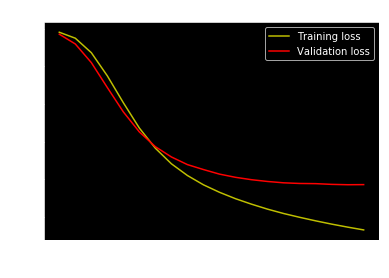

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

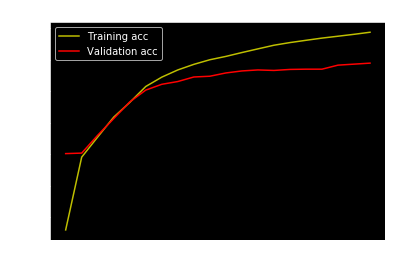

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(test_acc)

25000/25000 [==============================] - 1s 52us/step
0.88072


## Final Thoughts

When we’re working with categorical features with a lot of categories (i.e. words), we want to avoid using one hot encoding as it requires us to store a large matrix in memory and train a lot of parameters. Instead we can map each category to a n dimension embedding vector and train our machine learning model using the embedding vectors as input.